# Linear Cascaded Control

**NOTE** - completing this exercise without looking at the solution could take a few hours. Be prepared and good luck!

<img src="Drone2.png" width="300" height="300">

In this lesson we will be working with a simplified model of the 2D drone you worked with in the first lesson. We will be directly setting the vehicle's collective thrust through $u_1$ and the moment about the x axis, $M_x$ through $u_2$. We will ignore propeller rotation rates as well as the yaw-inducing moment $M_z$.

The state of this 2D drone can be described by the following vector: 

$$X = [z , y, \phi, \dot{z}, \dot{y},\dot{\phi}]$$


In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import trajectories
import simulate
import plotting

pylab.rcParams['figure.figsize'] = 10, 10

#### TODO 1 - Review Simplified `Drone2D` class
Walk through this code to refamiliarize youself with how state is represented, how controls are set, and what the underlying dynamics are.

In [2]:
class Drone2D:
    """
    Simulates the dynamics of a drone confined to 
    motion in the y-z plane. 
    """
    def __init__(self,
                 I_x = 0.1, # moment of inertia around the x-axis
                 m = 0.2,   # mass of the vehicle 
                ):
        
        self.I_x = I_x
        self.m = m
        
        self.u1 = 0.0 # collective thrust
        self.u2 = 0.0 # moment about the x axis
        self.g = 9.81
        
        # z, y, phi, z_dot, y_dot, phi_dot
        self.X = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    
    @property
    def y_dot_dot(self):
        phi = self.X[2]
        return self.u1 / self.m * np.sin(phi)
    
    @property
    def z_dot_dot(self):
        phi = self.X[2]
        return self.g - self.u1*np.cos(phi)/self.m
    
    @property
    def phi_dot_dot(self):
        return self.u2 / self.I_x
    
    def advance_state(self, dt):
        
        X_dot = np.array([self.X[3], 
                        self.X[4],
                        self.X[5], 
                        self.z_dot_dot,
                        self.y_dot_dot, 
                        self.phi_dot_dot])
        
        
        # Change in state will be 
        self.X = self.X + X_dot * dt
        return self.X 
    
    def set_controls(self, u1, u2):
        self.u1 = u1
        self.u2 = u2

### Linear Cascading Controller

In this section, you will create the controller described in class. The schematic description of the cascading controller looks like this:
<img src="CascadingController2.png" width="800" >

The controller architecture uses three **PD** controllers to control the drone (note that, for simplification, you will not need an I term for the controllers used in this exercise). 

One PD controller is used to generate the thrust and control the altitude while two PD controllers are used to control the lateral motion. The first receives the desired lateral position information containing $y$ , $\dot{y}$ and (optionally) $\ddot{y}$. Using this information as well as the current vehicle state, it outputs the commanded $\phi$ roll angle. 

The second PD controller is used to set a torque value $M_x$ to achieve the desired angle. In most cases, the inner controller responsible for roll angle operates at a higher frequency than the ones that are used to control the position. 

#### TODO - Implement 2D controller with LINEAR control equations.

The linear equations of motion are shown below.

$$\begin{align}
\ddot{z} &= g - \frac{u_1}{m}
\\
\\
\ddot{y} &= g \phi
\\
\\
\ddot{\phi} &= \frac{u_2}{I_x}
\end{align}$$

These equations can be solved for $u_1$, $\phi_{\text{command}}$, and $u_2$.

$$\begin{align}
u_1 &= m(g - \bar{u_1})
\\
\\
\phi_{\text{command}} &= \frac{\ddot{y}_{\text{target}}}{g}
\\
\\
u_2 &= I_x \bar{u}_2 
\end{align}$$

The first equation will be useful when implementing `altitude_controller`, the second when implementing `lateral_controller`, and the third when implementing `attitude_controller`.

Note that $\ddot{y}_{\text{target}}$ is like $\bar{u}_1$ or $\bar{u}_2$. It comes from PD control on the controller's inputs.

**Note the sequence of implementation, which should start from the INNER loop and then proceed with the OUTER loop.
In this specific case, you should start implementing the ATTITUDE controller first, then proceed with the LATERAL and ALTITUDE controller.**

In [3]:
class LinearCascadingController:
    
    def __init__(self,
                 m,   # needed to convert u1_bar to u1
                 I_x, # needed to convert u2_bar to u2
                 z_k_p=1.0,   
                 z_k_d=1.0,   
                 y_k_p=1.0,
                 y_k_d=1.0,
                 phi_k_p=1.0,
                 phi_k_d=1.0):
        
        self.z_k_p = z_k_p
        self.z_k_d = z_k_d   
        self.y_k_p = y_k_p
        self.y_k_d = y_k_d
        self.phi_k_p = phi_k_p
        self.phi_k_d = phi_k_d
        
        self.g = 9.81
        self.I_x = I_x
        self.m = m

    def altitude_controller(self, 
                    z_target, 
                    z_actual, 
                    z_dot_target, 
                    z_dot_actual,
                    z_dot_dot_target,
                    phi_actual, # unused parameter. Ignore for now.
                    ):
        """
        A PD controller which commands a thrust (u_1) 
        for the vehicle. 
        """
        
        #   Implement feedforward PD control to calculate
        #   u_1_bar and then use the linear math from above
        #   to transform u_1_bar into u_1 and then return u_1
        
        p = self.z_k_p * (z_target - z_actual)
        d = self.z_k_d * (z_dot_target - z_dot_actual)
        u1_bar = p + d + z_dot_dot_target        
        u_1 = self.m * (self.g - u1_bar)
        return u_1
    
    def lateral_controller(self, 
                        y_target, 
                        y_actual, 
                        y_dot_target, 
                        y_dot_actual,
                        u_1=None, # unused parameter. Ignore for now.
                        y_dot_dot_ff=0.0,
                        ):
        """
        A PD controller which commands a target roll 
        angle (phi_commanded).
        """
        
        #   Implement feedforward PD control to calculate
        #   y_dot_dot_target and then use the linear math from above
        #   to transform y_dot_dot_target into phi_commanded
        #   and then return phi_commanded
        p = self.y_k_p * (y_target - y_actual)
        d = self.y_k_d * (y_dot_target - y_dot_actual)
        y_dot_dot_target = p + d + y_dot_dot_ff        
        phi_commanded = y_dot_dot_target / self.g
        return phi_commanded 


    def attitude_controller(self, 
                            phi_target, 
                            phi_actual, 
                            phi_dot_actual,
                            phi_dot_target=0.0
                           ):
        """
        A PD controller which commands a moment (u_2)
        about the x axis for the vehicle.
        """
        
        #   Implement PD control to calculate u_2_bar
        #   and then use the linear math from above to
        #   transform u_2_bar into u_2 and then return u_2        
        p = self.phi_k_p * (phi_target - phi_actual)
        d = self.phi_k_d * (phi_dot_target - phi_dot_actual)
        u2_bar = p + d
        u_2 = self.I_x * u2_bar
        return u_2


The flight path we'll use to test our controller is a figure 8 described as follows:
$$
\begin{align}
z & = a_z \sin{\omega_z t} \\
y & = a_y \cos{\omega_y t}
\end{align}
$$

where $\omega_y = \omega_z / 2$. 

> NOTE - you can find the code that generates this trajectory in the file called `trajectories.py`, which you can access by clicking on the Jupyter logo in the top left corner of this notebook.

**NOTE on tuning:**
<br></br>

A good approach is to start with the inner loop, the ATTITUDE controller parameters (phi_k_p, phi_k_d) and the move forward with the LATERAL and ALTITUDE controller.
    
 1- increase phi_K_p until the drone is able to perform a shape smilar to the final path
 <br></br>
 <img src="phi_k_p.png" width="300" height="300">
        
 2- increase phi_k_d to align to the shape.
 
 3- Re-adjust phi_k_p until you get something similar to this:
 <br></br>
 <img src="phi_k_p2.png" width="300" height="300">
 
 4- At this point you can move forward with the outer loop for LATERAL postion. Increase y_k_d in order to align the shape in the y direction. Such as:
 <br></br>
 <img src="k_d.png" width="300" height="300">
 
 5- Slightly increase y_k_p.
 
 6- Now you can move on to the ALTITUDE controller and, as above, start increasing z_k_d and then slighlty increase z_k_p until you have a good overlap betwwen the planned and the executed path.
 

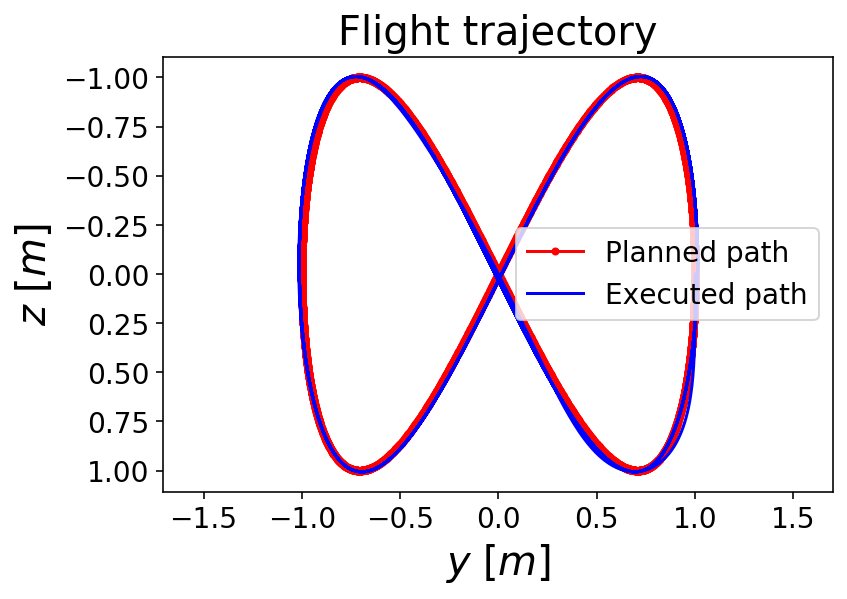

In [23]:
# TESTING CELL 
# 
# Note - this cell will only give nice output when your code
#  is working AND you've tuned your parameters correctly.
#  you might find it helpful to come up with a strategy
#  for first testing the inner loop controller and THEN 
#  testing the outer loop.
#
# Run this cell when you think your controller is ready!
#
# You'll have to tune the controller gains to get good results.

#### CONTROLLER GAINS (TUNE THESE) ######

z_k_p   = 2.0  
z_k_d   = 2.0  
y_k_p   = 2.2
y_k_d   = 2.0
phi_k_p = 16.0
phi_k_d = 4.0

#########################################

drone = Drone2D()

# INSTANTIATE CONTROLLER
linear_controller = LinearCascadingController(
    drone.m,
    drone.I_x,
    z_k_p=z_k_p,   
    z_k_d=z_k_d,   
    y_k_p=y_k_p,
    y_k_d=y_k_d,
    phi_k_p=phi_k_p,
    phi_k_d=phi_k_d
)

# TRAJECTORY PARAMETERS (you don't need to change these)
total_time = 100.0  
omega_z = 1.0       # angular frequency of figure 8

# GENERATE FIGURE 8
z_traj, y_traj, t = trajectories.figure_8(omega_z, total_time, dt=0.02)
z_path, z_dot_path, z_dot_dot_path = z_traj
y_path, y_dot_path, y_dot_dot_path = y_traj

# SIMULATE MOTION
linear_history     = simulate.zy_flight(z_traj, 
                                        y_traj,
                                        t, 
                                        linear_controller,
                                        inner_loop_speed_up=10)
# PLOT RESULTS
plotting.plot_zy_flight_path(z_path, y_path, linear_history)

If everything is working correctly you should see a blue figure 8 that (nearly) overlaps with a red figure 8.